## Install the required libraries and import them

In [ ]:
!pip install pychord

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pychord import Chord
import pickle
import json
import numpy as np

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 

import tensorflow as tf
import keras

import matplotlib.pyplot as plt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Load the dataset and the look-up table for pitches
The dataset was created using the *MIDI_chord_extraction.ipynb* script. It is also uploaded as a pickle file for convenience.


In [ ]:
# Load the dataset (chords from MIDIs) in pickle format
chords = pickle.load(open("soul_chords.pickle", "rb"))

In [ ]:
chords[0][0:5] #A sample of chords

[['Em'], ['GM7'], ['Gm'], ['GM7'], ['CM7/G']]

In [ ]:
# Load the lookup for pitch to number translation
with open('pitch_embedding.json') as d:
    pitches = json.load(d)

In [ ]:
# Replace the diminished and augmented chord notation to work with the PyChord library
chords = [[x[0].replace('o', 'dim') for x in song] for song in chords]
chords = [[x.replace('+', 'aug') for x in song] for song in chords]

In [ ]:
len(chords)

984

In [ ]:
# Show components of a random chord
e_chord = Chord(chords[0][0]).components_with_pitch(root_pitch=3)
e_chord

['G3', 'B3', 'D4']

In [ ]:
# Numeric representation of those components
e_nr = [int(pitches.get(item,item))  for item in e_chord]

np.array(e_nr)

array([ 8, 12, 15])

### One-octave embedding version

In [ ]:
# Show components of a random chord
e_chord = Chord(chords[0][0]).components()
e_chord

# Load the lookup for pitch to number translation (one octave version)
with open('pitch_embeddings_one_oct.json') as d:
    pitches = json.load(d)

# Numeric representation of those components
e_nr = [int(pitches.get(item,item))  for item in e_chord]

np.array(e_nr)

array([11,  9, 12,  3])

## Preprocess the input before building a model

In [ ]:
# Pre-processing the chords
# Splitting the pieces into smaller chunks
# One needs to come up with a smart way of splitting a piece into musical sentences (probably prior to conversion into chords)
# So here's a dumb way: just splitting everything into 24-chord-long sequences
def chunks(lst, n):
    #Yield successive n-sized chunks from lst.
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

chords_chunks = [list(chunks(x, 24)) for x in chords]
chords_chunks = [x for y in chords_chunks for x in y]
len(chords_chunks)

7488

In [ ]:
chords_chunks[1]

['G#aug/C',
 'Gdim/A#',
 'F#M7/C',
 'Ddim/C',
 'A#aug',
 'CM7/B',
 'G#aug/C',
 'A#aug/C',
 'Cm7',
 'A#aug/C',
 'Gm/C',
 'A#aug/C',
 'Gm/C',
 'Cm7',
 'G#dim/B',
 'G#aug/A#',
 'A#m7',
 'G#7/C',
 'Ddim/C',
 'C#M7/C',
 'G#aug/C',
 'A#7',
 'A#m7',
 'A#m7/C']

In [ ]:
# Intitialize the tokenizer and fit it
# We don't actually need a tokenizer, just a lookup function - but it's convenient
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(chords_chunks)
total_words = len(tokenizer.word_index) + 1
total_words # So in all the Soul songs there are only 36 unique chords

1044

This function creates sequences of varying length such that later we can try to predict their continuation

In [ ]:
# Create n-grams
# create input sequences using list of tokens

input_sequences = []
for line in chords_chunks:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

print("length on sequences:", len(input_sequences))
print('example sequences:', input_sequences[4], input_sequences[5])

length on sequences: 161149
example sequences: [677, 56, 712, 677, 256, 56] [677, 56, 712, 677, 256, 56, 256]


In [ ]:
# pad sequences (with 'pre' padding which works better for LSTM)
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
max_sequence_len

24

Here we take the last chord in each sequence and use it as a prediction label. This way we can train the algo to 'generate' a continuation of a provided sequence

In [ ]:
# Extract the last chord of sequence and convert it to categorical from numerical
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
predictors[54]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 362,  24, 263, 142,  14, 142, 205, 142, 205], dtype=int32)

In [ ]:
label[54]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
print(predictors.shape)
print(label.shape)

(161149, 23)
(161149, 1044)


Splitting the Data into Train and Test sets

In [ ]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(predictors, label, test_size=0.2, shuffle=True)

## A basic model with default (in-model) embeddings

In [ ]:
# Creating the model
model = Sequential()
model.add(Embedding(total_words, 32, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 32)            33408     
                                                                 
 bidirectional (Bidirectiona  (None, 23, 64)           16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 522)               8874      
                                                                 
 dense_1 (Dense)             (None, 1044)              546012    
                                                        

In [ ]:
history = model.fit(predictors, label, epochs=10, verbose=1, validation_data=(x_test, y_test))

Epoch 1/10
5036/5036 [==============================] - 230s 44ms/step - loss: 5.3792 - accuracy: 0.0361 - val_loss: 4.9938 - val_accuracy: 0.0545
Epoch 2/10
5036/5036 [==============================] - 218s 43ms/step - loss: 4.9044 - accuracy: 0.0613 - val_loss: 4.7840 - val_accuracy: 0.0674
Epoch 3/10
5036/5036 [==============================] - 219s 43ms/step - loss: 4.7377 - accuracy: 0.0710 - val_loss: 4.6499 - val_accuracy: 0.0756
Epoch 4/10
5036/5036 [==============================] - 218s 43ms/step - loss: 4.6357 - accuracy: 0.0790 - val_loss: 4.5601 - val_accuracy: 0.0862
Epoch 5/10
5036/5036 [==============================] - 216s 43ms/step - loss: 4.5592 - accuracy: 0.0865 - val_loss: 4.4797 - val_accuracy: 0.0941
Epoch 6/10
5036/5036 [==============================] - 216s 43ms/step - loss: 4.4950 - accuracy: 0.0929 - val_loss: 4.4179 - val_accuracy: 0.0980
Epoch 7/10
5036/5036 [==============================] - 215s 43ms/step - loss: 4.4371 - accuracy: 0.0985 - val_loss: 4

### Evaluating the model performance and generating some examples

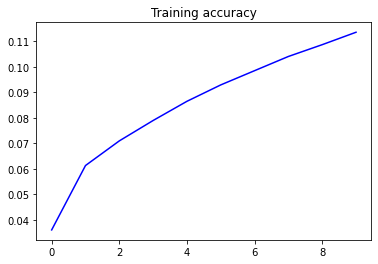

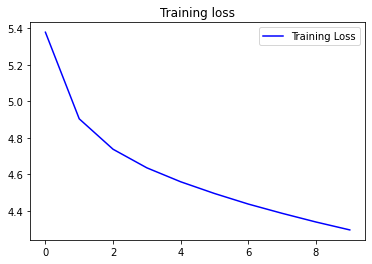

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

#### Generating a continuation for a I7 - IIIb7 progression

In [ ]:
seed_text = ['GM7', 'A#7']
next_words = 3

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = np.argmax(model.predict(token_list), axis=-1)\
    predicted = np.argsort(np.max(model.predict(token_list), axis=0))[-3] # a 'hotter' guess with the second most probable chord
    print(predicted)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text.append(output_word)
print(seed_text)

17
10
5
['GM7', 'A#7', 'Gm7', 'C7', 'Dm7']


## Using custom embeddings

### Create the embeddings

In [ ]:
word_index = tokenizer.word_index
voc = list(tokenizer.word_index.keys())
test = ["C", "C7", "G7"]
[word_index[w] for w in test]

[3, 10, 16]

In [ ]:
# A function to apply the embeddings
# for each chord it gives a numeric representation of the notes in it
# At most 5 notes are used (as the dataset does not contain more complex chords)
def embed_chord(chord):
  if chord == 'N':
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0])
  x = chord
  if 'E#' in x:
    x = x.replace("E#", "F")
  if 'B#' in x:
    x = x.replace("B#", "C")
  try:
    x = [float(pitches.get(item,item))  for item in Chord(x).components_with_pitch(root_pitch=3)]
    x += [0.0] * (5 - len(x))
  except:
    x= [0.0,0.0,0.0, 0.0, 0.0]
  return np.array(x)

In [ ]:
embeddings_index = {ch: embed_chord(ch) for ch in voc[:]}
list(embeddings_index.items())[0] # an arbitrary example

('CM7', array([ 1.,  5.,  8., 12.,  0.]))

Now use the tokenized values and the embeddings to create an embedding matrix

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 5
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        print(word)
        misses += 1
print("Converted %d chords (%d misses)" % (hits, misses))

Converted 1043 chords (0 misses)


### Build the model

In [ ]:
lr = 0.001
opt_adam = tf.optimizers.Adam(lr=lr)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Creating the model
model = Sequential()
# the custom embedding layer below
model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False))
model.add(Bidirectional(LSTM(50, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(25))
model.add(Dense(25, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 5)           5225      
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 100)        22400     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0         
                                                                 
 lstm_5 (LSTM)               (None, 25)                12600     
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 dense_5 (Dense)             (None, 1044)              27144     
                                                      

In [ ]:
# Add a callback for early stopping in case of no improvement
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
history = model.fit(predictors, label, epochs=80, verbose=1, batch_size=64, validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/80
2518/2518 [==============================] - 31s 11ms/step - loss: 5.6544 - accuracy: 0.0290 - val_loss: 5.4403 - val_accuracy: 0.0365
Epoch 2/80
2518/2518 [==============================] - 27s 11ms/step - loss: 5.3872 - accuracy: 0.0400 - val_loss: 5.2839 - val_accuracy: 0.0446
Epoch 3/80
2518/2518 [==============================] - 26s 10ms/step - loss: 5.2594 - accuracy: 0.0453 - val_loss: 5.1756 - val_accuracy: 0.0480
Epoch 4/80
2518/2518 [==============================] - 26s 10ms/step - loss: 5.1651 - accuracy: 0.0499 - val_loss: 5.0766 - val_accuracy: 0.0532
Epoch 5/80
2518/2518 [==============================] - 26s 10ms/step - loss: 5.0775 - accuracy: 0.0559 - val_loss: 4.9889 - val_accuracy: 0.0570
Epoch 6/80
2518/2518 [==============================] - 26s 10ms/step - loss: 5.0021 - accuracy: 0.0602 - val_loss: 4.9146 - val_accuracy: 0.0651
Epoch 7/80
2518/2518 [==============================] - 27s 11ms/step - loss: 4.9415 - accuracy: 0.0657 - val_loss: 4.8645 -

## Evaulating the model with custom embeddings

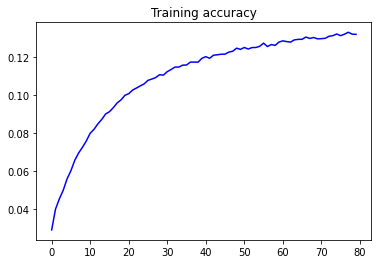

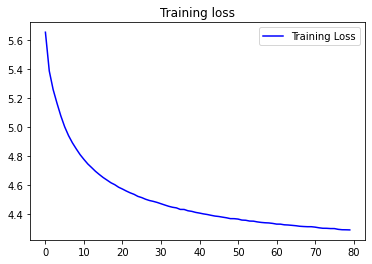

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show()

As we can see, the model converges faster and has lower loss than a model without custom embeddings

In [ ]:
seed_text = ["D7"]
next_chords = 3

for _ in range(next_chords):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = np.argmax(model.predict(token_list), axis=-1)
    predicted = np.argsort(np.max(model.predict(token_list), axis=0))[-2] # a 'hotter' guess with the second most probable chord
    print(predicted)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text.append(output_word)
print(seed_text)

46
5
6
['D7', 'D7/A', 'Dm7', 'D7']
